In [112]:
import numpy
import pandas
from pandas import concat

#Import sampling helper
from sklearn.model_selection import train_test_split
#Import preprocessing modules
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Binarizer
#Import random forest model
from sklearn.ensemble import RandomForestRegressor
#Import logist regression model
from sklearn.linear_model import LogisticRegression
#Import Linear regression model
from sklearn.linear_model import LinearRegression

#Import cross-validation pipelinePython
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

#Import evaluation metricsPython
from sklearn.metrics import mean_squared_error, r2_score

#Import module for saving scikit-learn modelsPython
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [27]:
ABInbevQuandl = pandas.read_csv('https://www.quandl.com/api/v3/datasets/EURONEXT/ABI.csv?api_key=_czXMKeX32eTXGttzD8H',
                                parse_dates=[0],
                                index_col=[0])

In [69]:
ABInbevQuandl.sort_index(inplace=True)
#feature 1 : High(j+1) < Low(j+2)
ABInbevQuandl['Feature1'] = (ABInbevQuandl['Low'].shift(-2) - ABInbevQuandl['High'].shift(-1))/ABInbevQuandl['High'].shift(-1)
#feature 2 : High(j+1) < Low(j+3)
ABInbevQuandl['Feature2'] = (ABInbevQuandl['Low'].shift(-3) - ABInbevQuandl['High'].shift(-1))/ABInbevQuandl['High'].shift(-1) 
#feature 3 : High(j+1) < Low(j+4)
ABInbevQuandl['Feature3'] = (ABInbevQuandl['Low'].shift(-4) - ABInbevQuandl['High'].shift(-1))/ABInbevQuandl['High'].shift(-1) 
#feature 4 : High(j+1) < Low(j+5)
ABInbevQuandl['Feature4'] = (ABInbevQuandl['Low'].shift(-5) - ABInbevQuandl['High'].shift(-1))/ABInbevQuandl['High'].shift(-1) 
ABInbevQuandl.dropna(inplace=True)


In [31]:
#take only Date, High and Low
ABReg = ABInbevQuandl[['High','Low']]
ABReg.reset_index(inplace=True)

#Regression calculation
RegResult = pandas.DataFrame(columns=['Date','nbdays','score','coef_high','coef_low'])
X = numpy.array(ABReg.index).reshape(-1,1)
y = numpy.array(ABReg[['High','Low']])
index=0 

#taking all combination of subset from -> to
#actually we don't take subset of 1 and 2 days 
#because there is no point to calculate regression with less than 3 points
for i in range(ABReg.index.size-2):
    for j in range(i+3,max(i+350,ABReg.index.size)):        
        temp = LinearRegression().fit(X[i:j],y[i:j])
        y_reg = temp.predict(X[i:j])
        score=r2_score(y[i:j],y_reg)
        if (score >= 0.9):
            RegResult.loc[index] = \
                [ABReg.loc[j-1,'Date'],\
                 j-i,\
                 score,\
                 temp.coef_[0].item(),\
                 temp.coef_[1].item()]
            index += 1
    



In [95]:
AggResult = RegResult.groupby(by='Date').agg({'nbdays': ['min','max','count'],\
                              'coef_high': ['min','max','mean'],\
                              'coef_low': ['min','max','mean']})
AggResult.columns = AggResult.columns.map(lambda x: '_'.join([str(i) for i in x]))

ABInbevToAnalyse = ABInbevQuandl.join(AggResult)

In [136]:
#define the target rate
y = pandas.DataFrame(Binarizer(0).fit_transform(ABInberToAnalyse[['Feature2']]))
X = ABInberToAnalyse.drop(['Feature1','Feature2','Feature3','Feature4'], axis=1).fillna(0)



In [137]:
#Split data into train and test setsPython
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.8, 
                                                    random_state=123, 
                                                    stratify=y)

logisticRegr = LogisticRegression()

logisticRegr.fit(X_train, y_train)

predictions = logisticRegr.predict(X_test)

score = logisticRegr.score(X_test, y_test)

cm = metrics.confusion_matrix(y_test, predictions)


C:\Users\pierr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\pierr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


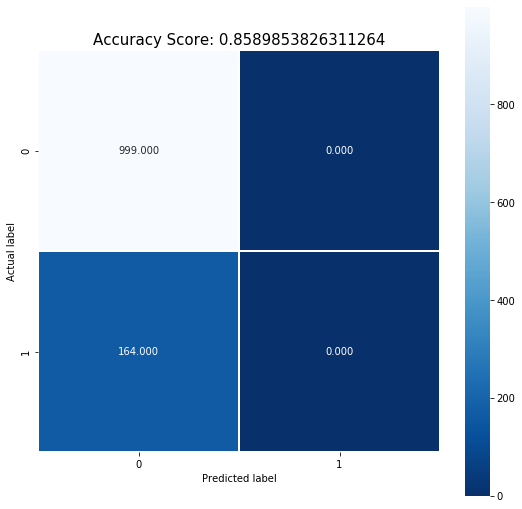

In [138]:
    
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
